# US–CN Spillover Analysis
This notebook contains only the **useful code snippets** we built:
- data + lag creation
- VAR and Granger
- Diebold–Yilmaz style spillover (GFEVD)
- rolling correlation of GARCH-standardized residuals
- ML baselines (linear, XGBoost) with **time-series CV**
- extension for richer features (momentum, vol, corr)

Replace the `data`-loading cell with your own source.

In [2]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

# optional ML
import xgboost as xgb

# optional GARCH
from arch import arch_model

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

## 1. Load / prepare base data
We expect a DataFrame `data` with at least:
- `Date` (datetime)
- `US_Ret` (weekly return)
- `CN_Ret` (weekly return)

Sample rows:
        Date   US_Close   CN_Close  US_Ret  CN_Ret
0 2005-01-14 2,087.9100 1,245.6200 -0.0003  0.0007
1 2005-01-21 2,034.2700 1,234.4800 -0.0260 -0.0090
2 2005-01-28 2,035.8300 1,213.6700  0.0008 -0.0170
3 2005-02-04 2,086.6600 1,269.0000  0.0247  0.0446
4 2005-02-11 2,076.6600 1,269.0000 -0.0048  0.0000


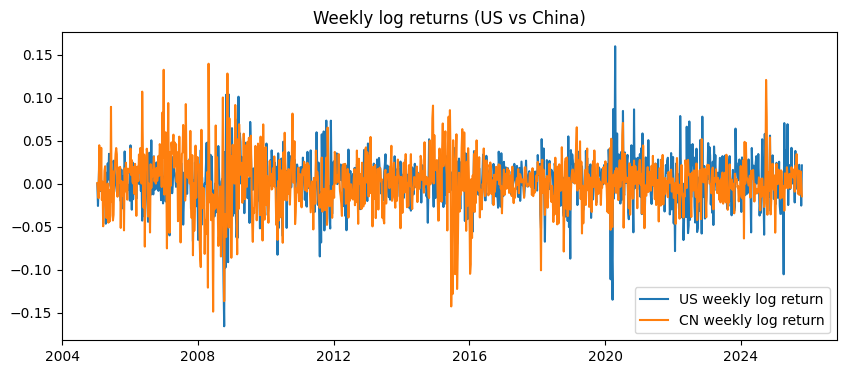

In [3]:
us = pd.read_csv('Project/us_index.csv', parse_dates=['Date']).sort_values('Date')
cn = pd.read_csv('Project/cn_index.csv', parse_dates=['Date']).sort_values('Date')

us_w = us.set_index('Date')['Close']   # keine Resample nötig
cn_w = cn.set_index('Date')['Close']

# Resample both series to weekly (Friday close). If your data is already weekly, this will simply keep it.
us_w = us.set_index('Date')['Close'].resample('W-FRI').last().ffill()
cn_w = cn.set_index('Date')['Close'].resample('W-FRI').last().ffill()


# Build DataFrame with log returns
data = pd.DataFrame({'US_Close': us_w, 'CN_Close': cn_w}).dropna()
# Log returns: simple and commonly used for VAR / GARCH
data['US_Ret'] = np.log(data['US_Close']).diff()
data['CN_Ret'] = np.log(data['CN_Close']).diff()
# drop the first NA after differencing
data = data.dropna().reset_index().rename(columns={'index': 'Date'})


print('Sample rows:')
print(data.head())


plt.figure(figsize=(10,4))
plt.plot(data['Date'], data['US_Ret'], label='US weekly log return')
plt.plot(data['Date'], data['CN_Ret'], label='CN weekly log return')
plt.legend()
plt.title('Weekly log returns (US vs China)')
plt.show()



In [4]:
assert "Date" in data.columns
assert "US_Ret" in data.columns
assert "CN_Ret" in data.columns

data = data.sort_values("Date").reset_index(drop=True)

## 2. Lag construction helper
Corrected version (the first one returned after lag 1).

In [5]:
def make_lags(df: pd.DataFrame, lags: int = 4) -> pd.DataFrame:
    """Create US/CN lag features per date.
    Expects columns: Date, US_Ret, CN_Ret
    """
    tmp = df.copy().set_index("Date")
    for i in range(1, lags + 1):
        tmp[f"CN_lag{i}"] = tmp["CN_Ret"].shift(i)
        tmp[f"US_lag{i}"] = tmp["US_Ret"].shift(i)
    tmp = tmp.dropna().reset_index()
    return tmp

lags = 4
ml_df = make_lags(data, lags=lags)
ml_df.head()

,Date,US_Close,CN_Close,US_Ret,CN_Ret,CN_lag1,US_lag1,CN_lag2,US_lag2,CN_lag3,US_lag3,CN_lag4,US_lag4
0,2005-02-11,"2,076.6600","1,269.0000",-0.0048,0.0000,0.0446,0.0247,-0.0170,0.0008,-0.0090,-0.0260,0.0007,-0.0003
1,2005-02-18,"2,058.6200","1,258.9700",-0.0087,-0.0079,0.0000,-0.0048,0.0446,0.0247,-0.0170,0.0008,-0.0090,-0.0260
2,2005-02-25,"2,065.4000","1,312.4500",0.0033,0.0416,-0.0079,-0.0087,0.0000,-0.0048,0.0446,0.0247,-0.0170,0.0008
3,2005-03-04,"2,070.6100","1,287.7100",0.0025,-0.0190,0.0416,0.0033,-0.0079,-0.0087,0.0000,-0.0048,0.0446,0.0247
4,2005-03-11,"2,041.6000","1,289.9400",-0.0141,0.0017,-0.0190,0.0025,0.0416,0.0033,-0.0079,-0.0087,0.0000,-0.0048


## 3. VAR(1) and Granger causality (US ↔ CN)
Order selection showed lag=1 was sufficient.

In [6]:
# prepare for VAR
var_data = data[["US_Ret", "CN_Ret"]].set_index(data["Date"])  # index for convenience

# VAR(1)
model = VAR(var_data)
res = model.fit(1)
print(res.summary())

# Granger: does CN -> US?
print("\nGranger test: CN → US (H0: no causality)")
grangercausalitytests(var_data[["US_Ret", "CN_Ret"]], maxlag=4, verbose=True)

# Granger: does US -> CN?
print("\nGranger test: US → CN (H0: no causality)")
grangercausalitytests(var_data[["CN_Ret", "US_Ret"]], maxlag=4, verbose=True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Oct, 2025
Time:                     12:41:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.1224
Nobs:                     1083.00    HQIC:                  -14.1396
Log likelihood:           4594.84    FPE:                7.15654e-07
AIC:                     -14.1501    Det(Omega_mle):     7.11705e-07
--------------------------------------------------------------------
Results for equation US_Ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002355         0.000846            2.782           0.005
L1.US_Ret        -0.052851         0.030922           -1.709           0.087
L1.CN_Ret        -0.034977         0.027457           -1.274           0.20

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(18.246463080185187),
    np.float64(2.1118391795043864e-05),
    np.float64(1080.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(18.297147699852367),
    np.float64(1.8898992480170294e-05),
    np.int64(1)),
   'lrtest': (np.float64(18.144302832120957),
    np.float64(2.0478116034061885e-05),
    np.int64(1)),
   'params_ftest': (np.float64(18.246463080185436),
    np.float64(2.11183917950382e-05),
    np.float64(1080.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(11.34525097236939),
    np.float64(1.3304726331267783e-05),
    np.float64(1077.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(22.79584317939402),
    np.float64(1.1218777851464502e-05),
    np.int64(2)),
   'lrtest': (np.float64(22.559029346077295),
    np.float64(1.2629001619815764e-05),
    np.int64(2)),
   'params_ftest': (np.float64(11.345250972368754),
    np.float64(1.3304726331276787e-05),
    np.float64(1077.0),
    2.0)},
   arr

## 4. Diebold–Yilmaz-style GFEVD spillover (2 variables)
This matches the code you ran, but wrapped once.

In [7]:
def gfevd_spillover(res, h: int = 10, labels=("US", "CN")):
    """Compute generalized FEVD matrix and total spillover index for a fitted VAR.
    res ... statsmodels VARResults
    h  ... forecast horizon
    """
    Psi = np.asarray(res.ma_rep(maxn=h - 1))   # (h, k, k)
    Sigma = np.asarray(res.sigma_u)            # (k, k)
    k = Psi.shape[1]
    sigma_diag = np.diag(Sigma).astype(float)

    num = np.zeros((k, k), dtype=float)
    den = np.zeros(k, dtype=float)

    for s in range(h):
        Ps = Psi[s]               # (k, k)
        B = Ps @ Sigma            # (k, k)
        num += (B * B) / sigma_diag[np.newaxis, :]
        den += np.sum(B * Ps, axis=1)

    GFEVD = num / den.reshape(-1, 1)
    GFEVD = GFEVD / GFEVD.sum(axis=1, keepdims=True)

    off_diag = GFEVD.sum() - np.trace(GFEVD)
    total_spill = off_diag / k

    idx = [f"{l}_recipient" for l in labels[:k]]
    cols = [f"{l}_source" for l in labels[:k]]
    df = pd.DataFrame(GFEVD, index=idx, columns=cols)
    return total_spill, df

total_spill, spill_df = gfevd_spillover(res, h=10, labels=("US", "CN"))
print(f"Total spillover index (h=10): {total_spill:.4f}")
print("\nFEVD share matrix (rows=recipient, cols=source):")
print(spill_df.round(4))

Total spillover index (h=10): 0.0491

FEVD share matrix (rows=recipient, cols=source):
              US_source  CN_source
US_recipient     0.9586     0.0414
CN_recipient     0.0567     0.9433


## 5. Rolling correlation of GARCH-standardized residuals
This shows time-varying co-movement of shocks.

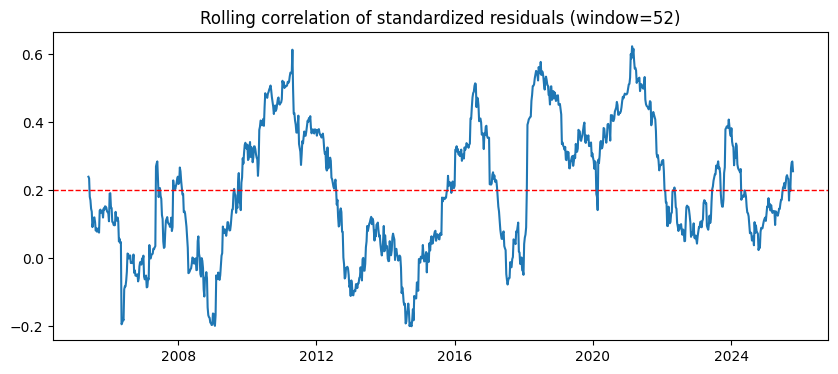

Average rolling correlation: 0.1998


In [8]:
# fit univariate GARCH(1,1) for both (scale by 100)
us_garch = arch_model(data["US_Ret"] * 100, p=1, q=1).fit(disp="off")
cn_garch = arch_model(data["CN_Ret"] * 100, p=1, q=1).fit(disp="off")

us_std = us_garch.resid / us_garch.conditional_volatility
cn_std = cn_garch.resid / cn_garch.conditional_volatility

std = pd.concat([
    data["Date"],
    us_std.rename("US_std"),
    cn_std.rename("CN_std")
], axis=1).dropna()

roll_corr = std["US_std"].rolling(window=52, min_periods=20).corr(std["CN_std"])

plt.figure(figsize=(10, 4))
plt.plot(std["Date"], roll_corr)
plt.title("Rolling correlation of standardized residuals (window=52)")
plt.axhline(roll_corr.mean(), color="red", linestyle="--", linewidth=1)
plt.show()

print(f"Average rolling correlation: {roll_corr.mean():.4f}")

## 6. Time-series ML: linear baseline, XGBoost
We predict **CN_Ret** from its own lags **plus** US lags (the version that worked best).

In [9]:
lags = 4
ml_df = make_lags(data, lags=lags)

cn_feats = [f"CN_lag{i}" for i in range(1, lags + 1)]
us_feats = [f"US_lag{i}" for i in range(1, lags + 1)]
features = cn_feats + us_feats

X = ml_df[features].values
y = ml_df["CN_Ret"].values

print("ML sample size:", X.shape)
print("Features:", features)

tscv = TimeSeriesSplit(n_splits=5)

# 6.1 linear baseline
preds_lin = np.zeros_like(y, dtype=float)
for train_idx, test_idx in tscv.split(X):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])

    lr = LinearRegression()
    lr.fit(X_train, y[train_idx])
    preds_lin[test_idx] = lr.predict(X_test)

print("Lin RMSE:", np.sqrt(mean_squared_error(y, preds_lin)))
print("Lin R2:", r2_score(y, preds_lin))

# 6.2 XGBoost with same splits
preds_xgb = np.zeros_like(y, dtype=float)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds_xgb[test_idx] = model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y, preds_xgb)))
print("XGBoost R2:", r2_score(y, preds_xgb))

ML sample size: (1080, 8)
Features: ['CN_lag1', 'CN_lag2', 'CN_lag3', 'CN_lag4', 'US_lag1', 'US_lag2', 'US_lag3', 'US_lag4']
Lin RMSE: 0.03231377450788082
Lin R2: -0.06500019345118568
XGBoost RMSE: 0.03543175134585606
XGBoost R2: -0.2804409221944184


## 7. NN template with time-series CV
Note: with weekly returns this will likely **not** beat the linear model — kept here as template.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

preds_nn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
    # scale per fold to avoid lookahead
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])
    y_train = y[train_idx]
    y_test = y[test_idx]

    nn = Sequential([
        Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    nn.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)

    nn.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=60,
        verbose=0,
        callbacks=[es]
    )

    preds_nn[test_idx] = nn.predict(X_test, verbose=0).flatten()

print("NN RMSE:", np.sqrt(mean_squared_error(y, preds_nn)))
print("NN R2:", r2_score(y, preds_nn))

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_reg

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN RMSE: 0.07483821302677966
NN R2: -4.712433066927362


## 8. Enriching features: momentum, volatility, rolling corr
To improve predictability, add state variables.

In [11]:
df = data.copy()
df["US_mom_12"] = df["US_Ret"].rolling(12).sum()
df["CN_mom_12"] = df["CN_Ret"].rolling(12).sum()
df["US_vol_12"] = df["US_Ret"].rolling(12).std()
df["CN_vol_12"] = df["CN_Ret"].rolling(12).std()
df["rollcorr_12"] = df["US_Ret"].rolling(12).corr(df["CN_Ret"])
df = df.dropna().reset_index(drop=True)

ml_df2 = make_lags(df, lags=4)
lag_feats = [c for c in ml_df2.columns if "lag" in c]
extra_feats = ["US_mom_12", "CN_mom_12", "US_vol_12", "CN_vol_12", "rollcorr_12"]
features2 = lag_feats + extra_feats

X2 = ml_df2[features2].values
y2 = ml_df2["CN_Ret"].values

tscv = TimeSeriesSplit(n_splits=5)
preds_xgb2 = np.zeros_like(y2, dtype=float)
for train_idx, test_idx in tscv.split(X2):
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=150, random_state=42)
    model.fit(X2[train_idx], y2[train_idx])
    preds_xgb2[test_idx] = model.predict(X2[test_idx])

print("XGB (enriched) RMSE:", np.sqrt(mean_squared_error(y2, preds_xgb2)))
print("XGB (enriched) R2:", r2_score(y2, preds_xgb2))

XGB (enriched) RMSE: 0.0338056903519063
XGB (enriched) R2: -0.16254634946669966
